In [1]:
# setting up the notebook width to 100% of the screen
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# 1. import libraries

In [2]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import json

from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from scipy.stats import uniform, randint

## 2. load data

In [86]:
df = pd.read_csv("./fraud_oracle.csv")

In [4]:
!pip install sweetviz


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import sweetviz as sv

                                             |          | [  0%]   00:00 -> (? left)


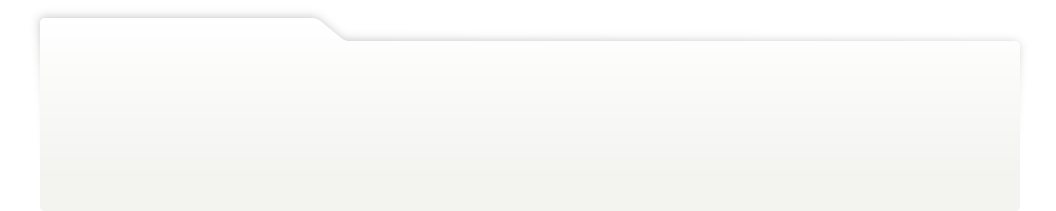
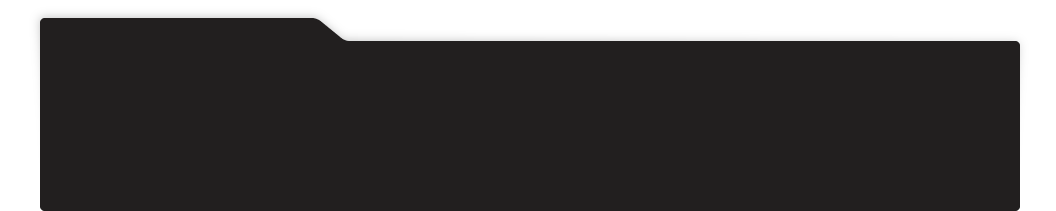
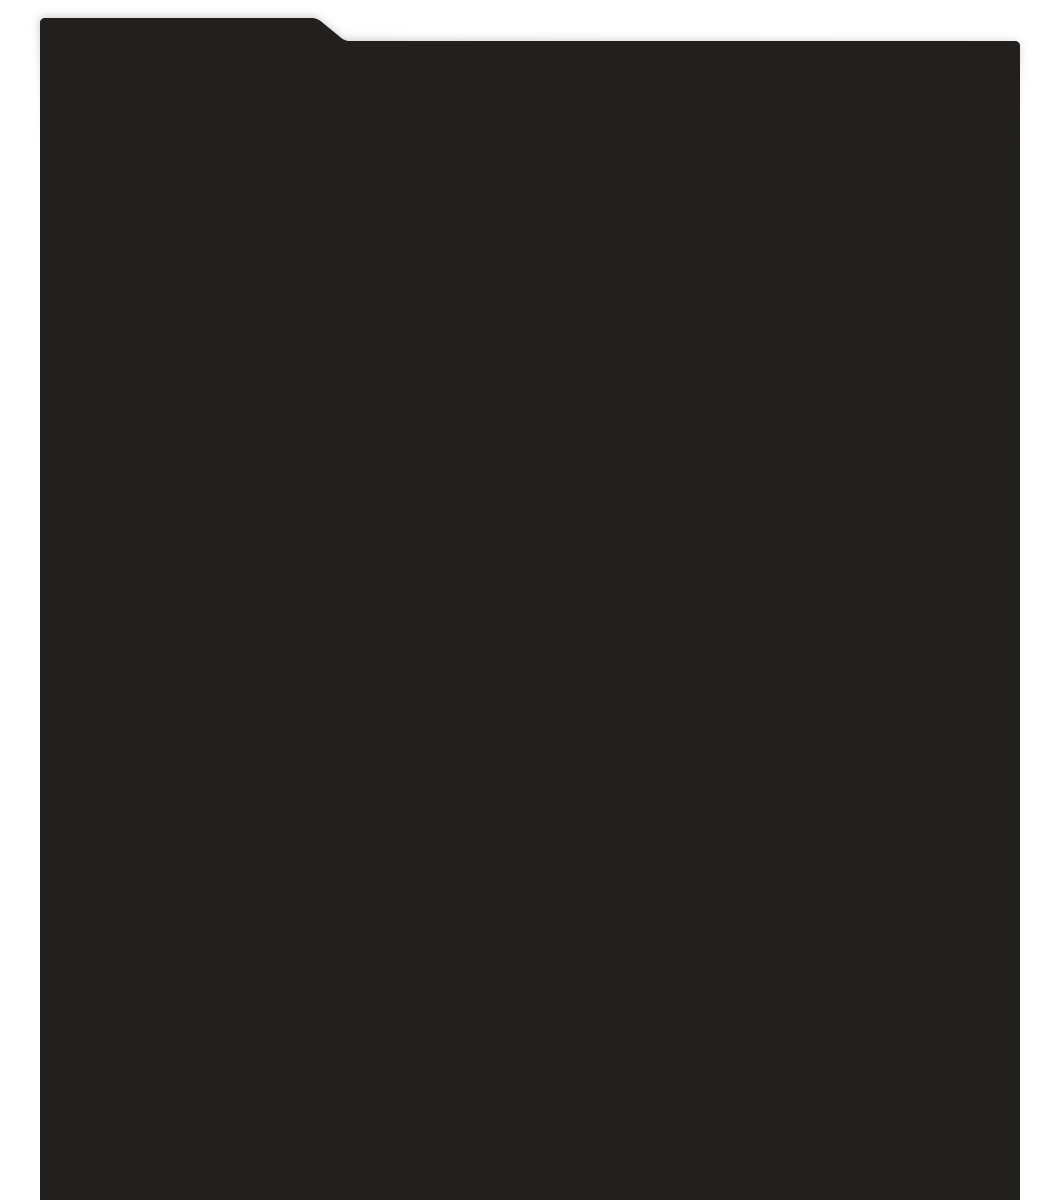
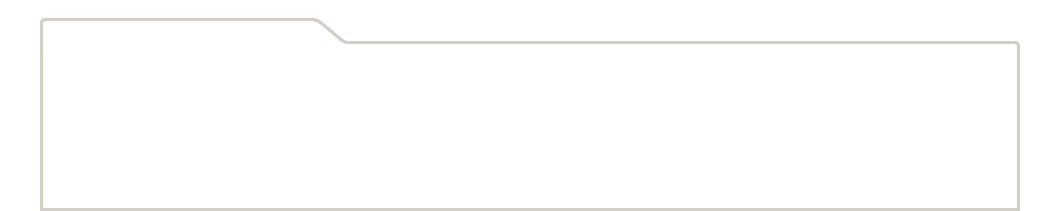
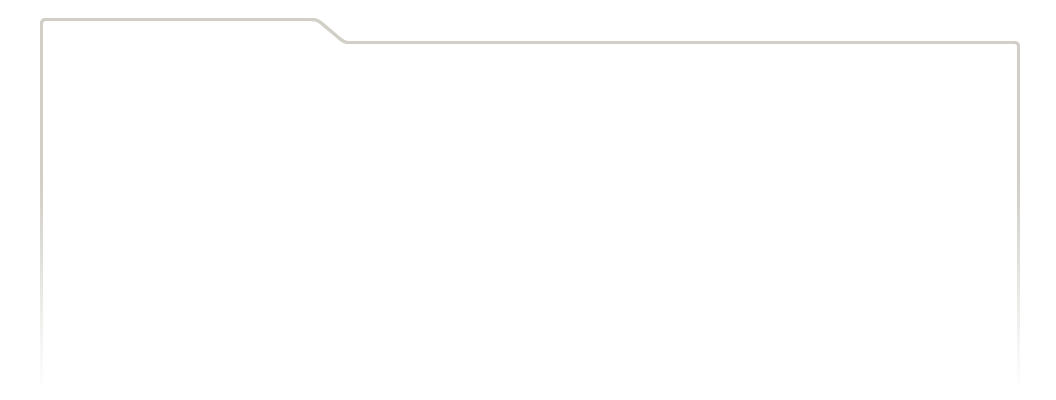
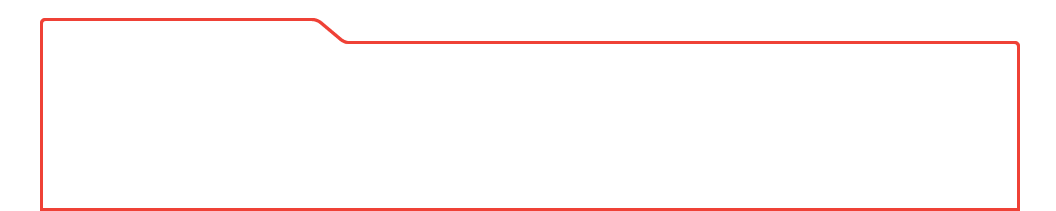
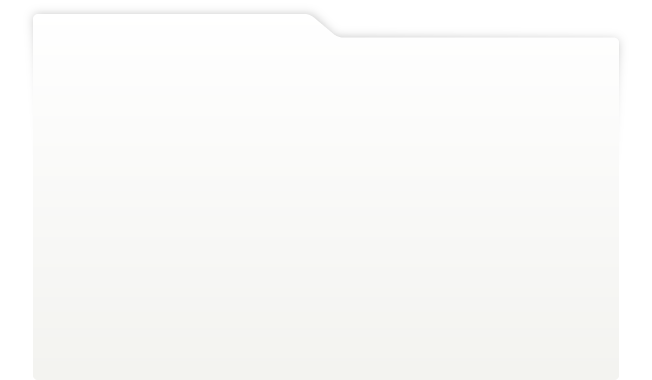
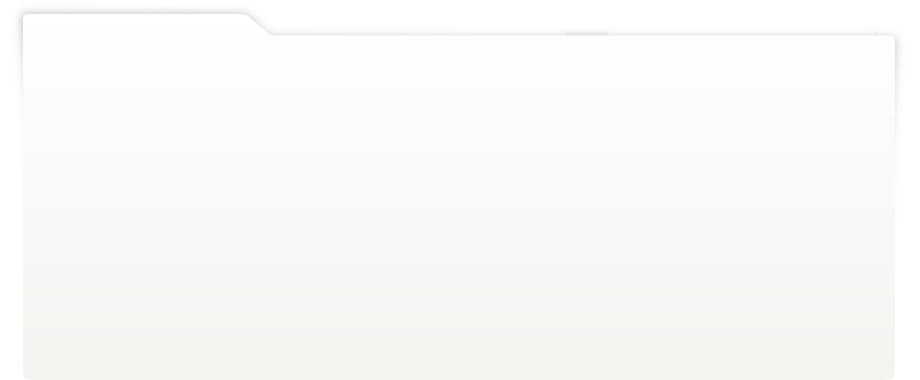
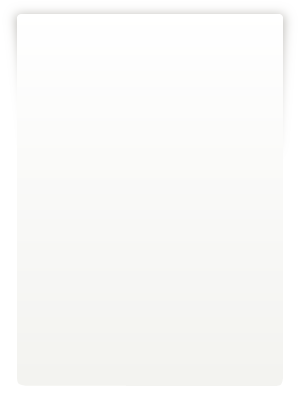
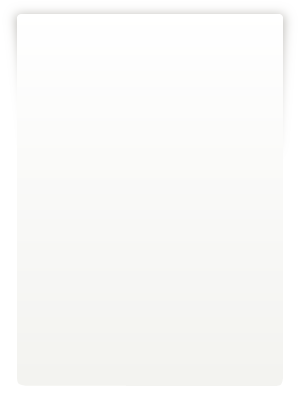
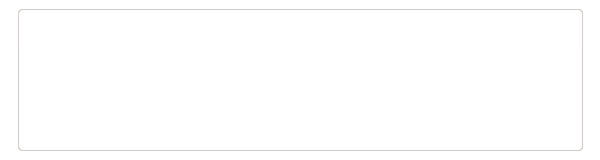
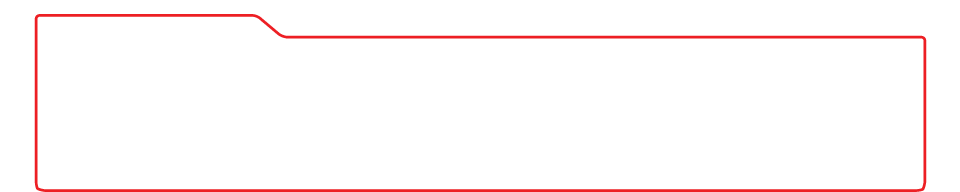
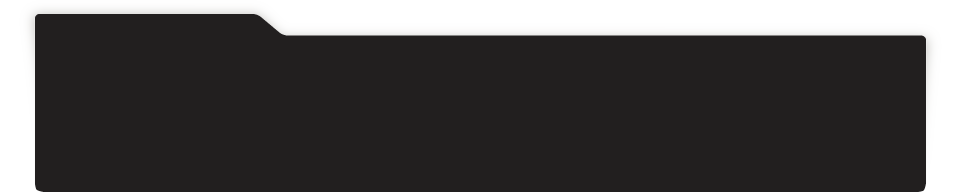
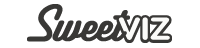
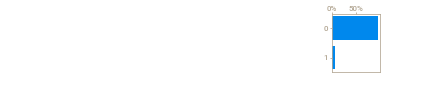
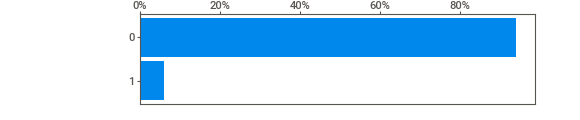
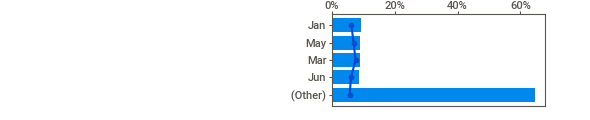
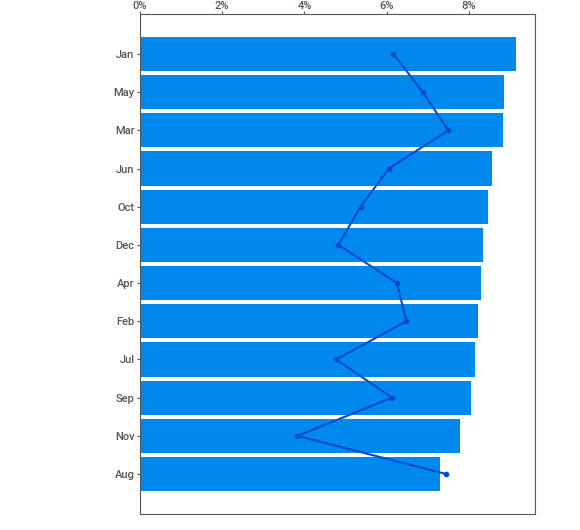
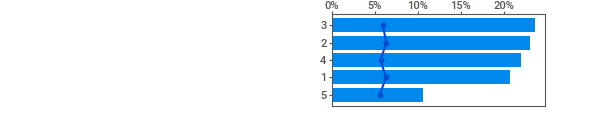
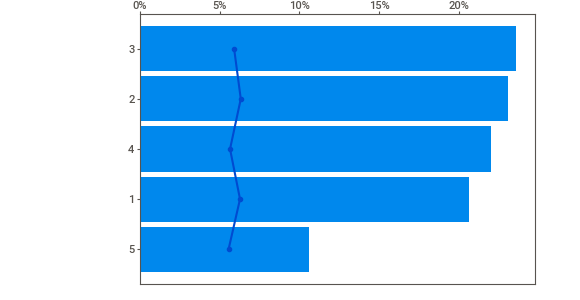
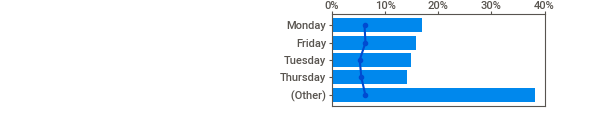
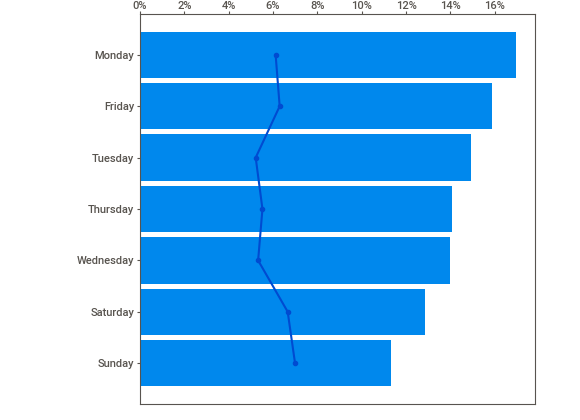
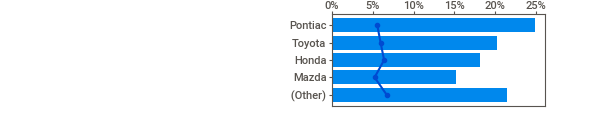
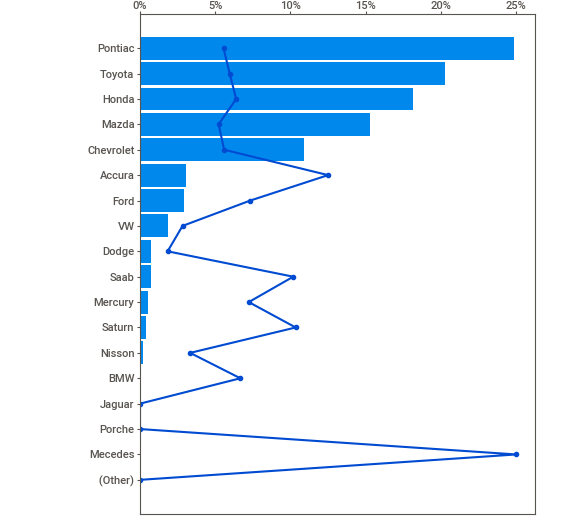
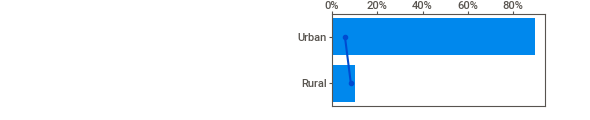
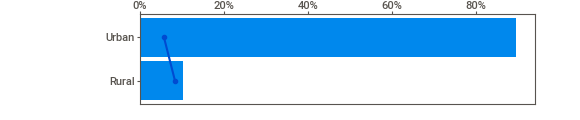
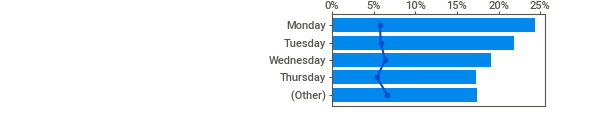
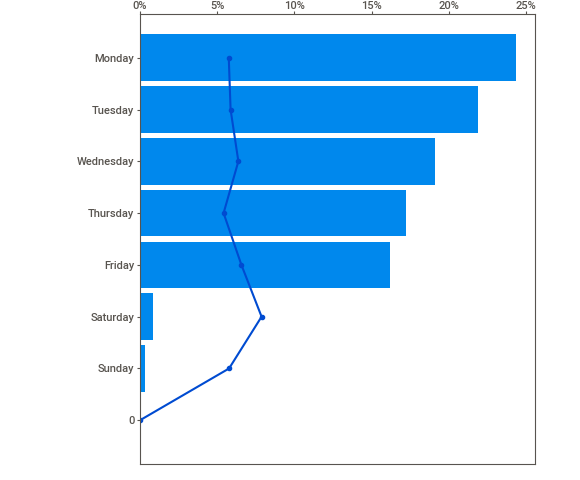
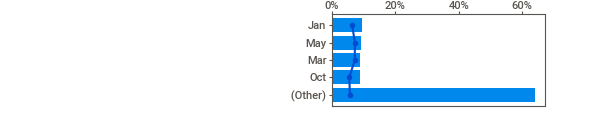
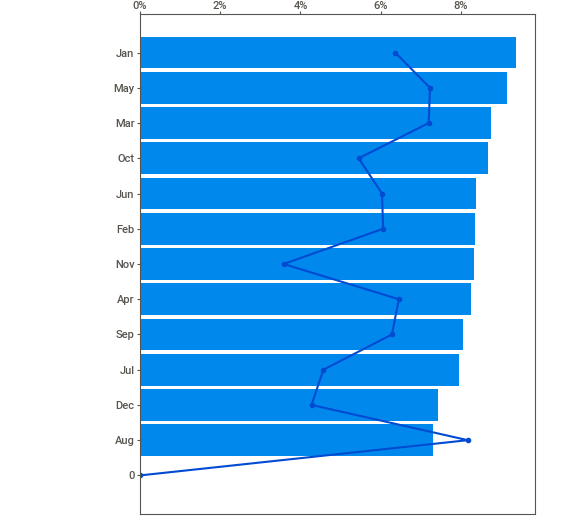
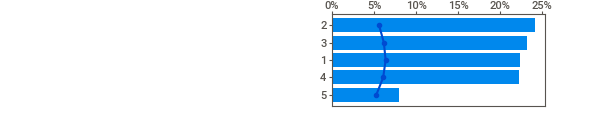
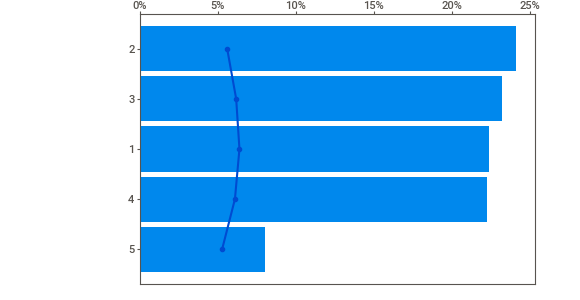
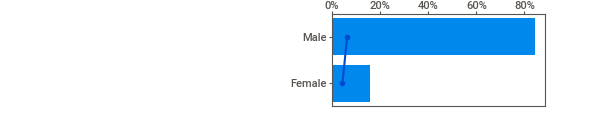
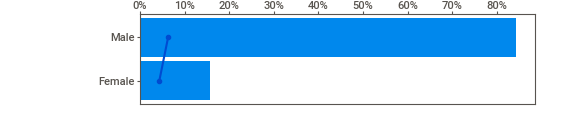
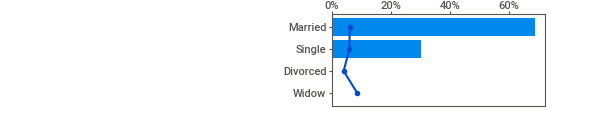
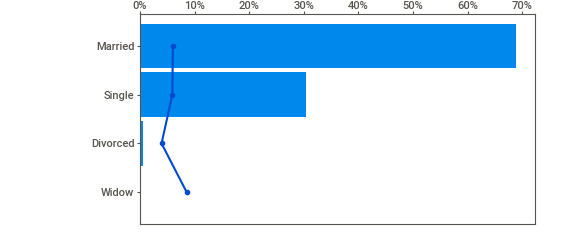
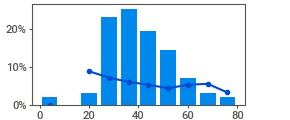
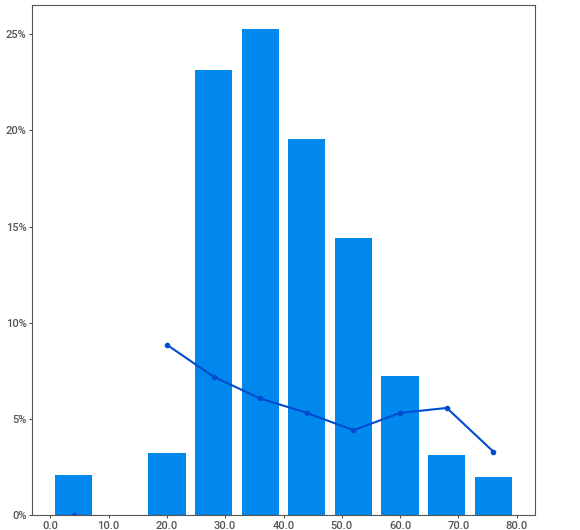
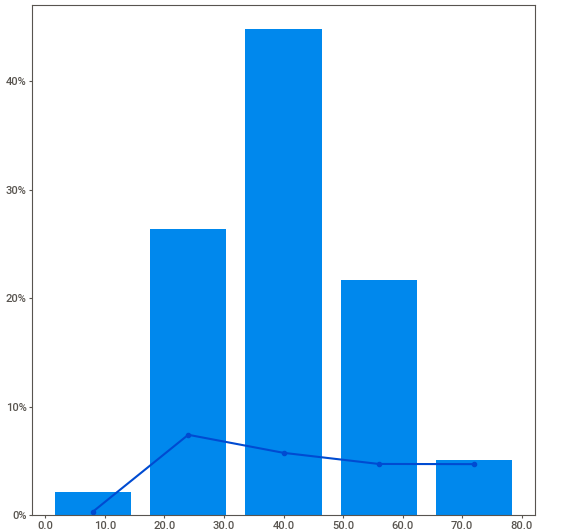
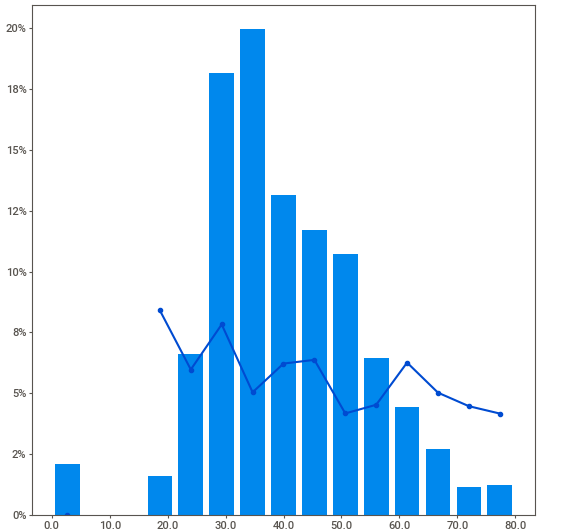
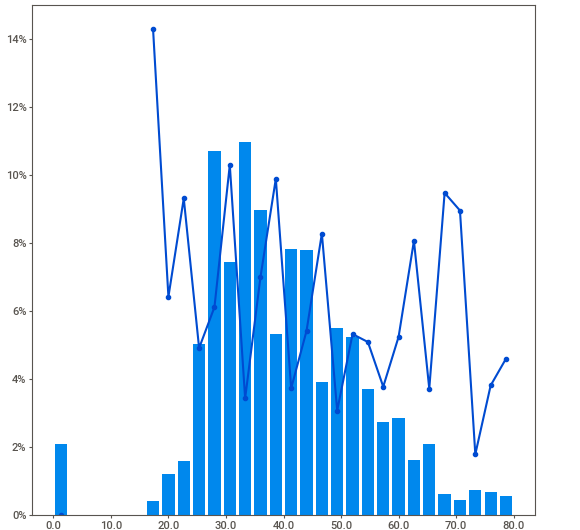
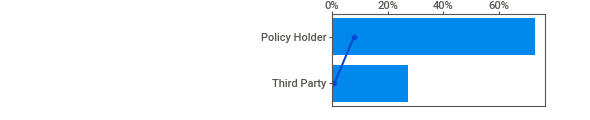
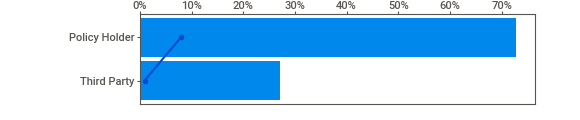
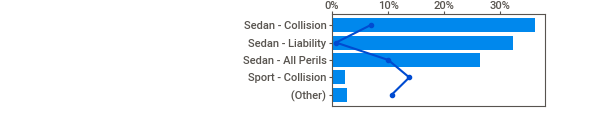
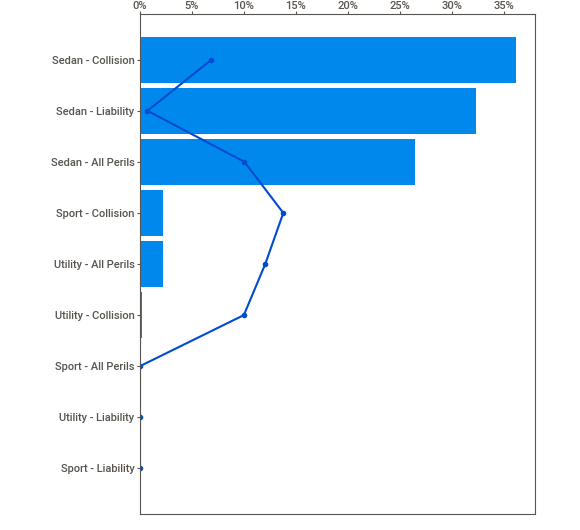
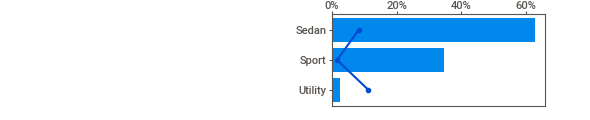
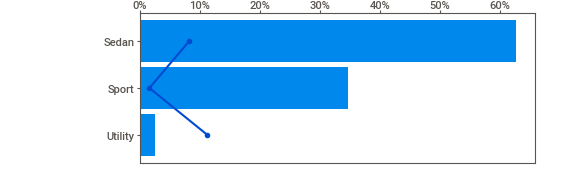
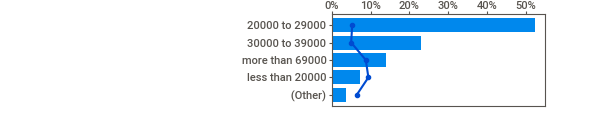
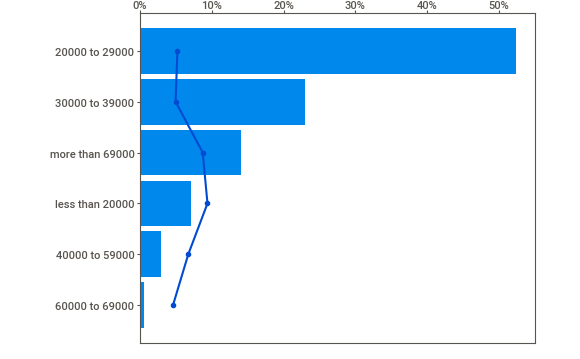
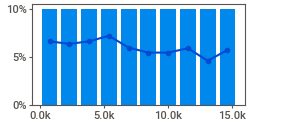
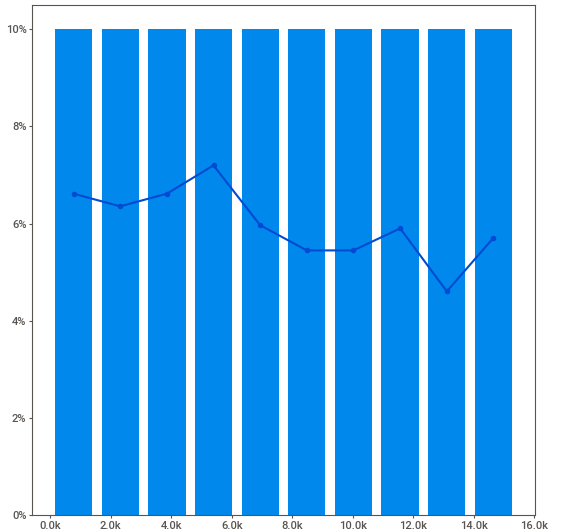
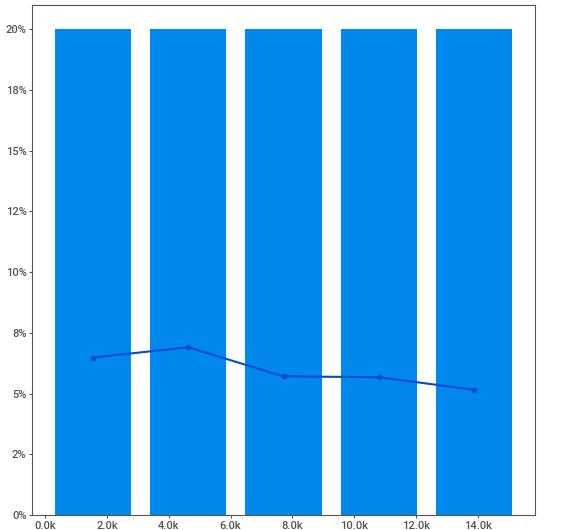
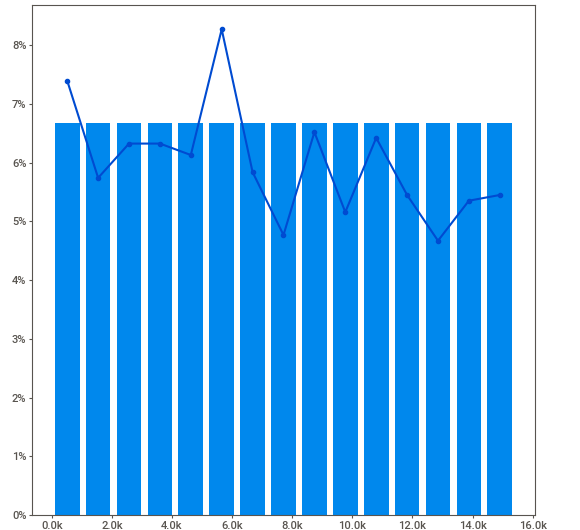
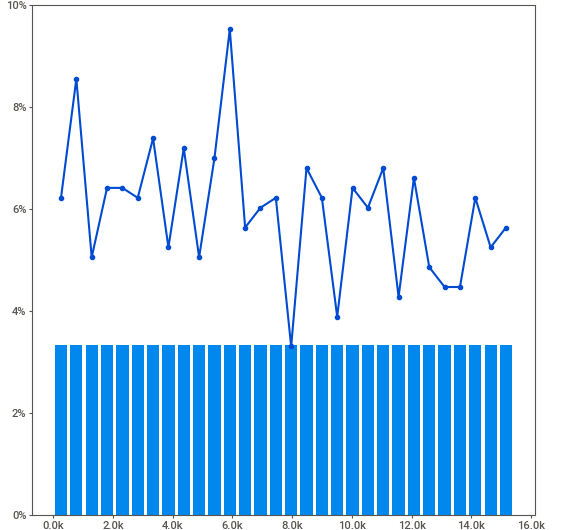
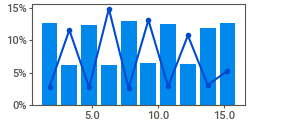
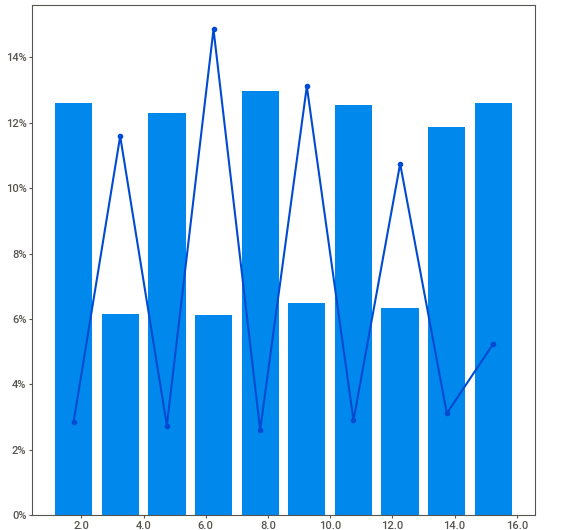
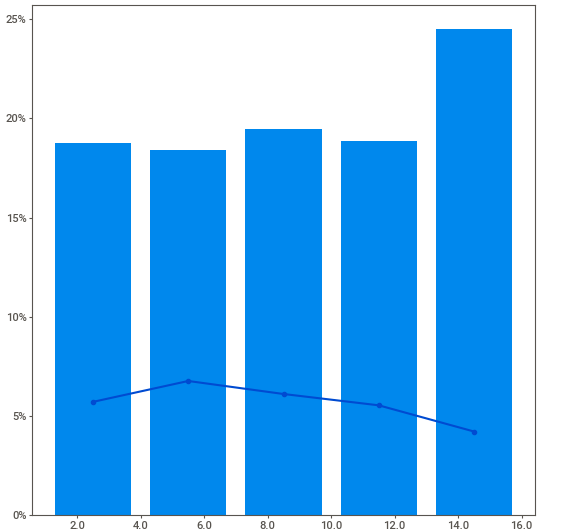
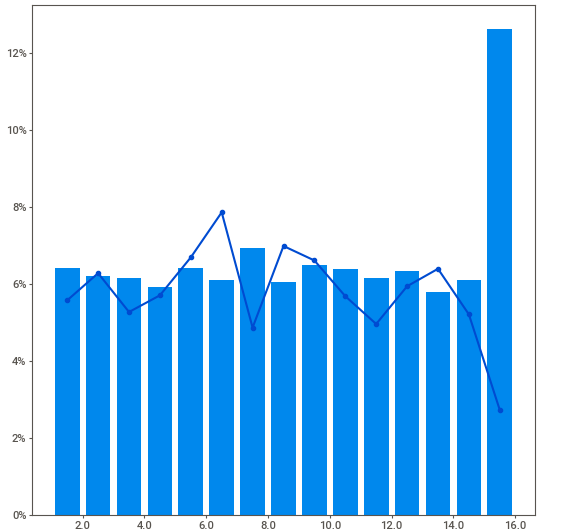
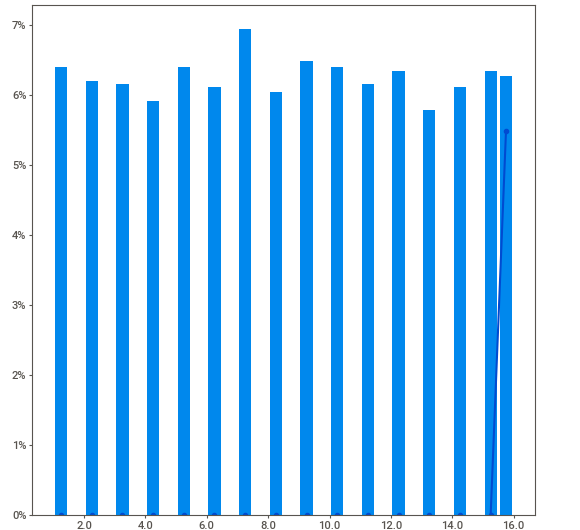
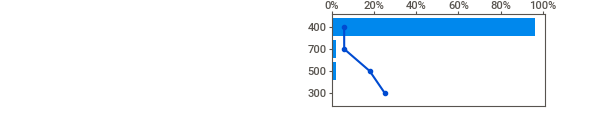
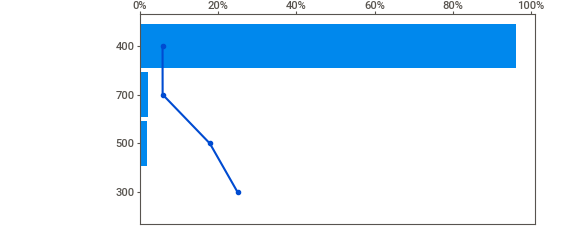
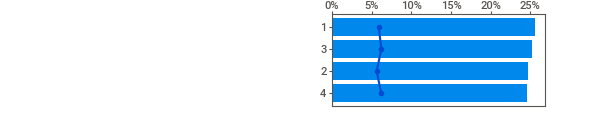
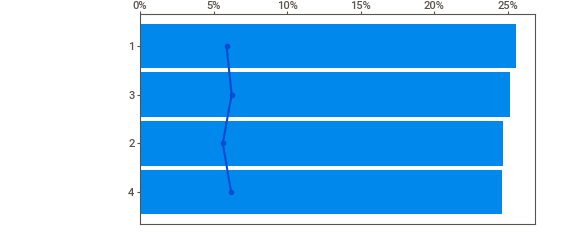
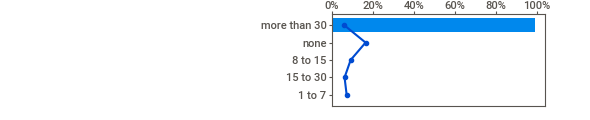
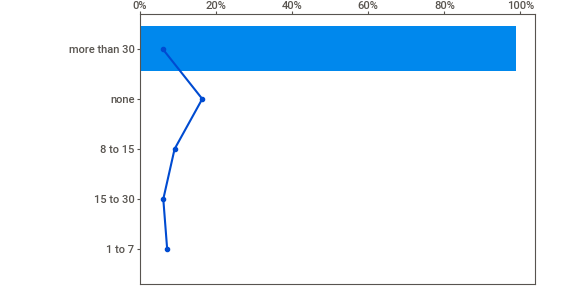
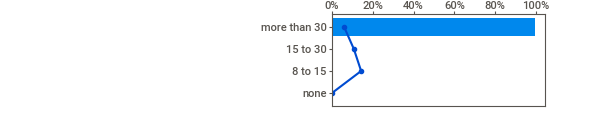
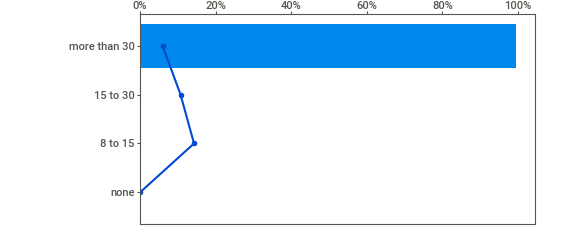
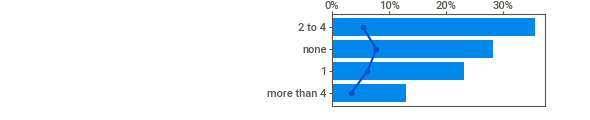
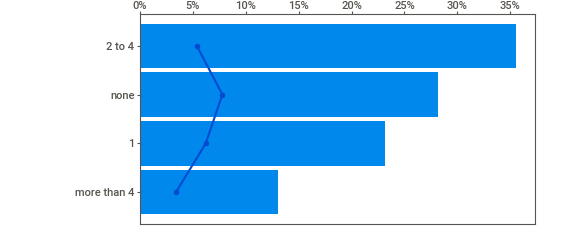
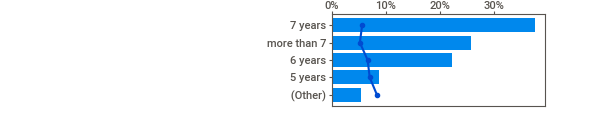
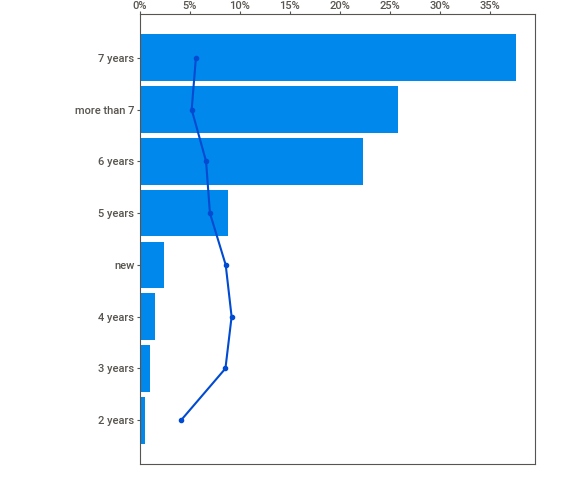
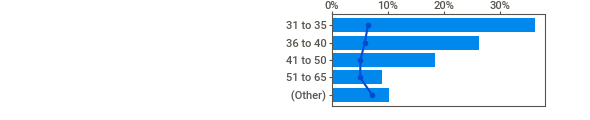
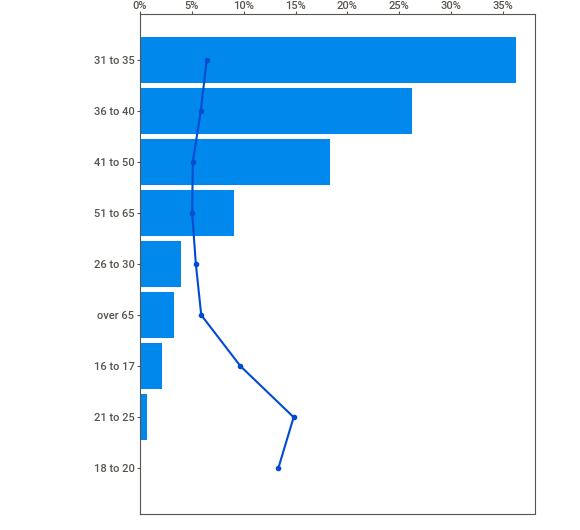
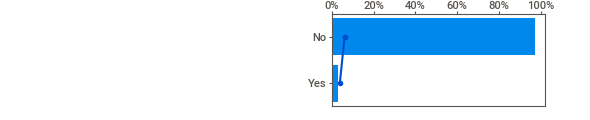
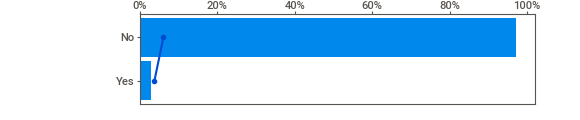
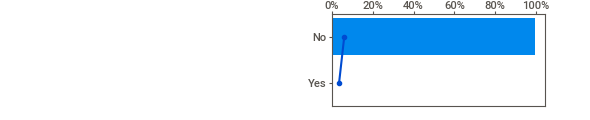
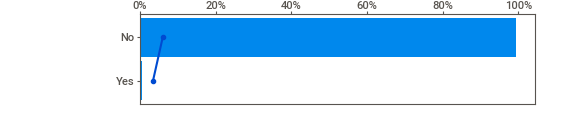
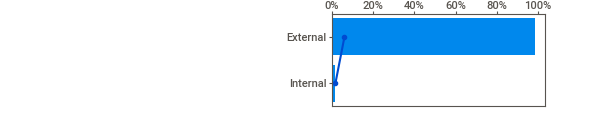
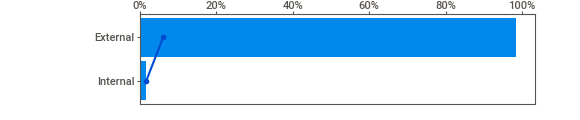
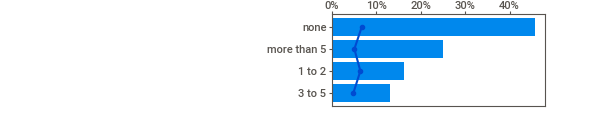
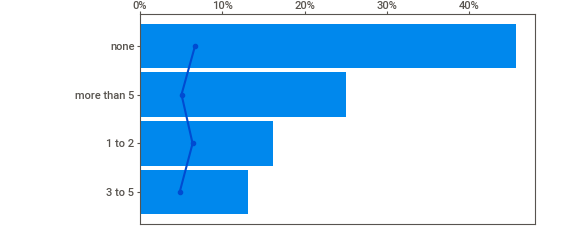
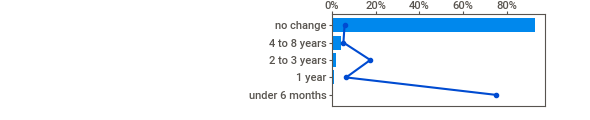
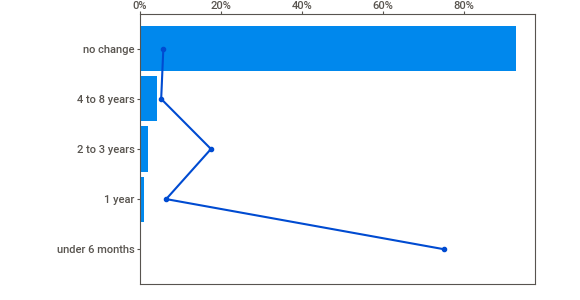
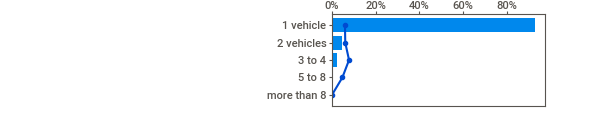
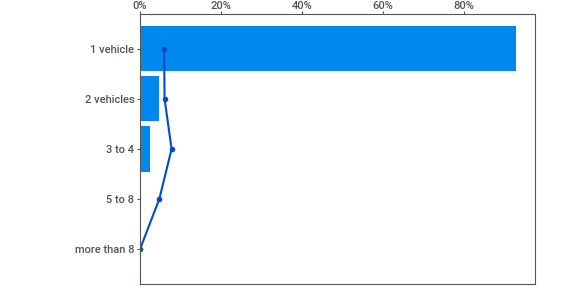
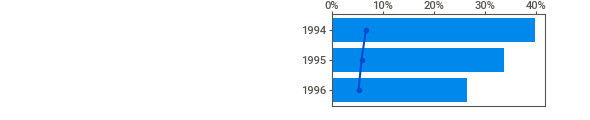
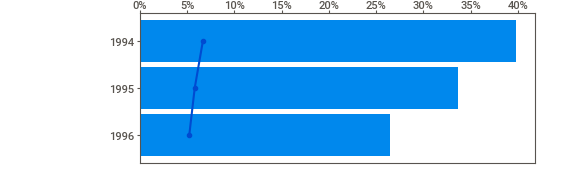
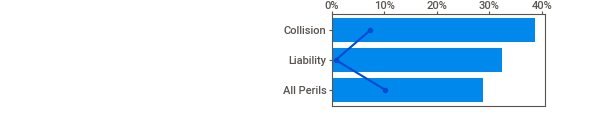
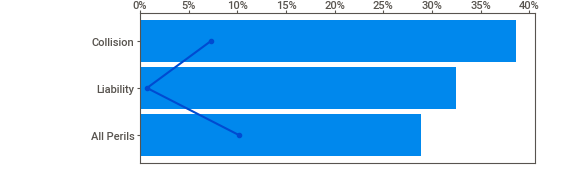
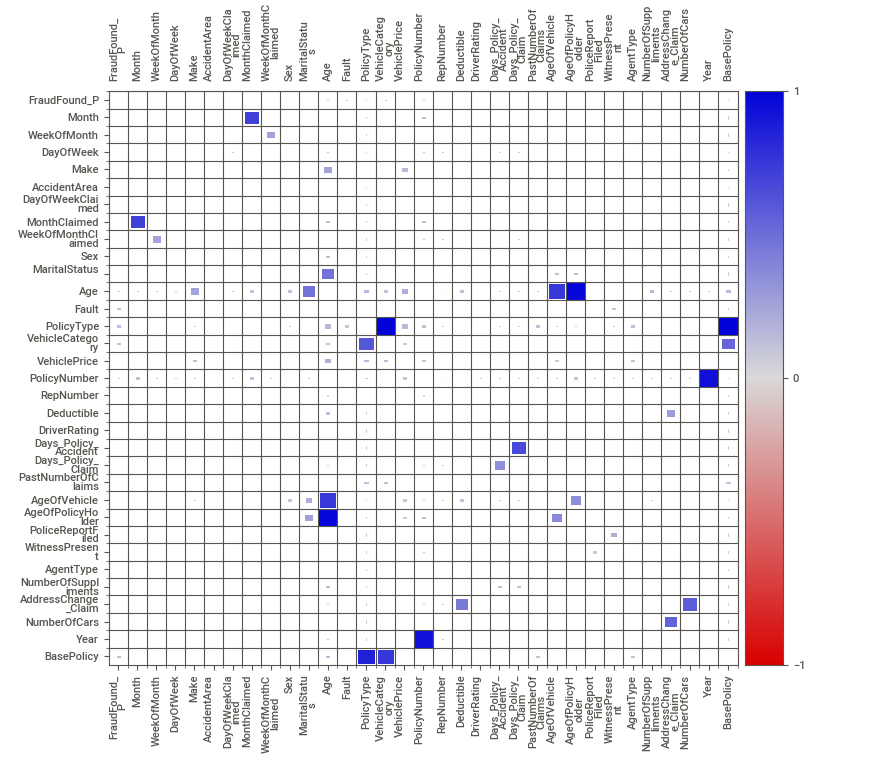
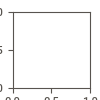

In [6]:
analyze_report = sv.analyze([df,'Train'], 'FraudFound_P')


analyze_report.show_notebook(w=900, h=450, scale=0.8)

## 3. data cleaning

In [87]:
df.shape

(15420, 33)

In [88]:
df.head().T

,0,1,2,3,4
Month,Dec,Jan,Oct,Jun,Jan
WeekOfMonth,5,3,5,2,5
DayOfWeek,Wednesday,Wednesday,Friday,Saturday,Monday
Make,Honda,Honda,Honda,Toyota,Honda
AccidentArea,Urban,Urban,Urban,Rural,Urban
DayOfWeekClaimed,Tuesday,Monday,Thursday,Friday,Tuesday
MonthClaimed,Jan,Jan,Nov,Jul,Feb
WeekOfMonthClaimed,1,4,2,1,2
Sex,Female,Male,Male,Male,Female
MaritalStatus,Single,Single,Married,Married,Single


### 3.0 remove serial number like columns

In [91]:
df.drop(columns="PolicyNumber", inplace=True)

### 3.1 check data types consistency

In [92]:
df.dtypes.value_counts()

object    24
int64      8
dtype: int64

In [93]:
df.select_dtypes(['object']).columns.tolist()

['Month',
 'DayOfWeek',
 'Make',
 'AccidentArea',
 'DayOfWeekClaimed',
 'MonthClaimed',
 'Sex',
 'MaritalStatus',
 'Fault',
 'PolicyType',
 'VehicleCategory',
 'VehiclePrice',
 'Days_Policy_Accident',
 'Days_Policy_Claim',
 'PastNumberOfClaims',
 'AgeOfVehicle',
 'AgeOfPolicyHolder',
 'PoliceReportFiled',
 'WitnessPresent',
 'AgentType',
 'NumberOfSuppliments',
 'AddressChange_Claim',
 'NumberOfCars',
 'BasePolicy']

In [94]:
len(df.select_dtypes(['object']).applymap(type).value_counts())

1

### 3.2 check null values and column types¶ 

In [95]:
df.info(show_counts=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

#### 3.2.1 confirm that there are no null values

In [96]:
df.isnull().any(axis=0).any()

False

### 3.3 check for duplicates

In [97]:
print(f"{len(df[df.duplicated()])} entries are duplicates")

0 entries are duplicates


## 4. data analysis and feature extraction

### 4.1 univariate and bivariate analysis of original data

#### 4.1.1 univariate analysis

In [98]:
df.FraudFound_P.value_counts()

0    14497
1      923
Name: FraudFound_P, dtype: int64

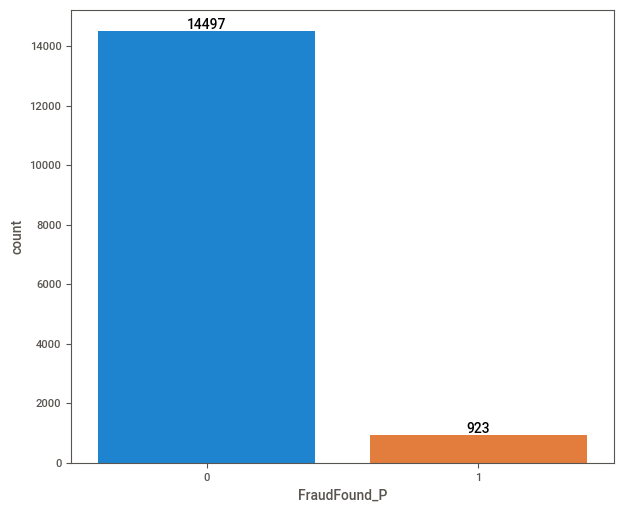

In [99]:
plt.figure(figsize=(7,6))
ax=sns.countplot(data=df, x='FraudFound_P');
ax.bar_label(ax.containers[0]);

In [100]:
df.FraudFound_P.value_counts(normalize=1) * 100.

0    94.014267
1     5.985733
Name: FraudFound_P, dtype: float64

#### 4.1.2 bivariate analysis

In [101]:
df.select_dtypes(["int", "float"])

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,RepNumber,Deductible,DriverRating,Year
0,5,1,21,0,12,300,1,1994
1,3,4,34,0,15,400,4,1994
2,5,2,47,0,7,400,3,1994
3,2,1,65,0,4,400,2,1994
4,5,2,27,0,3,400,1,1994
...,...,...,...,...,...,...,...,...
15415,4,5,35,1,5,400,4,1996
15416,5,1,30,0,11,400,3,1996
15417,5,1,24,1,4,400,4,1996
15418,1,2,34,0,6,400,4,1996


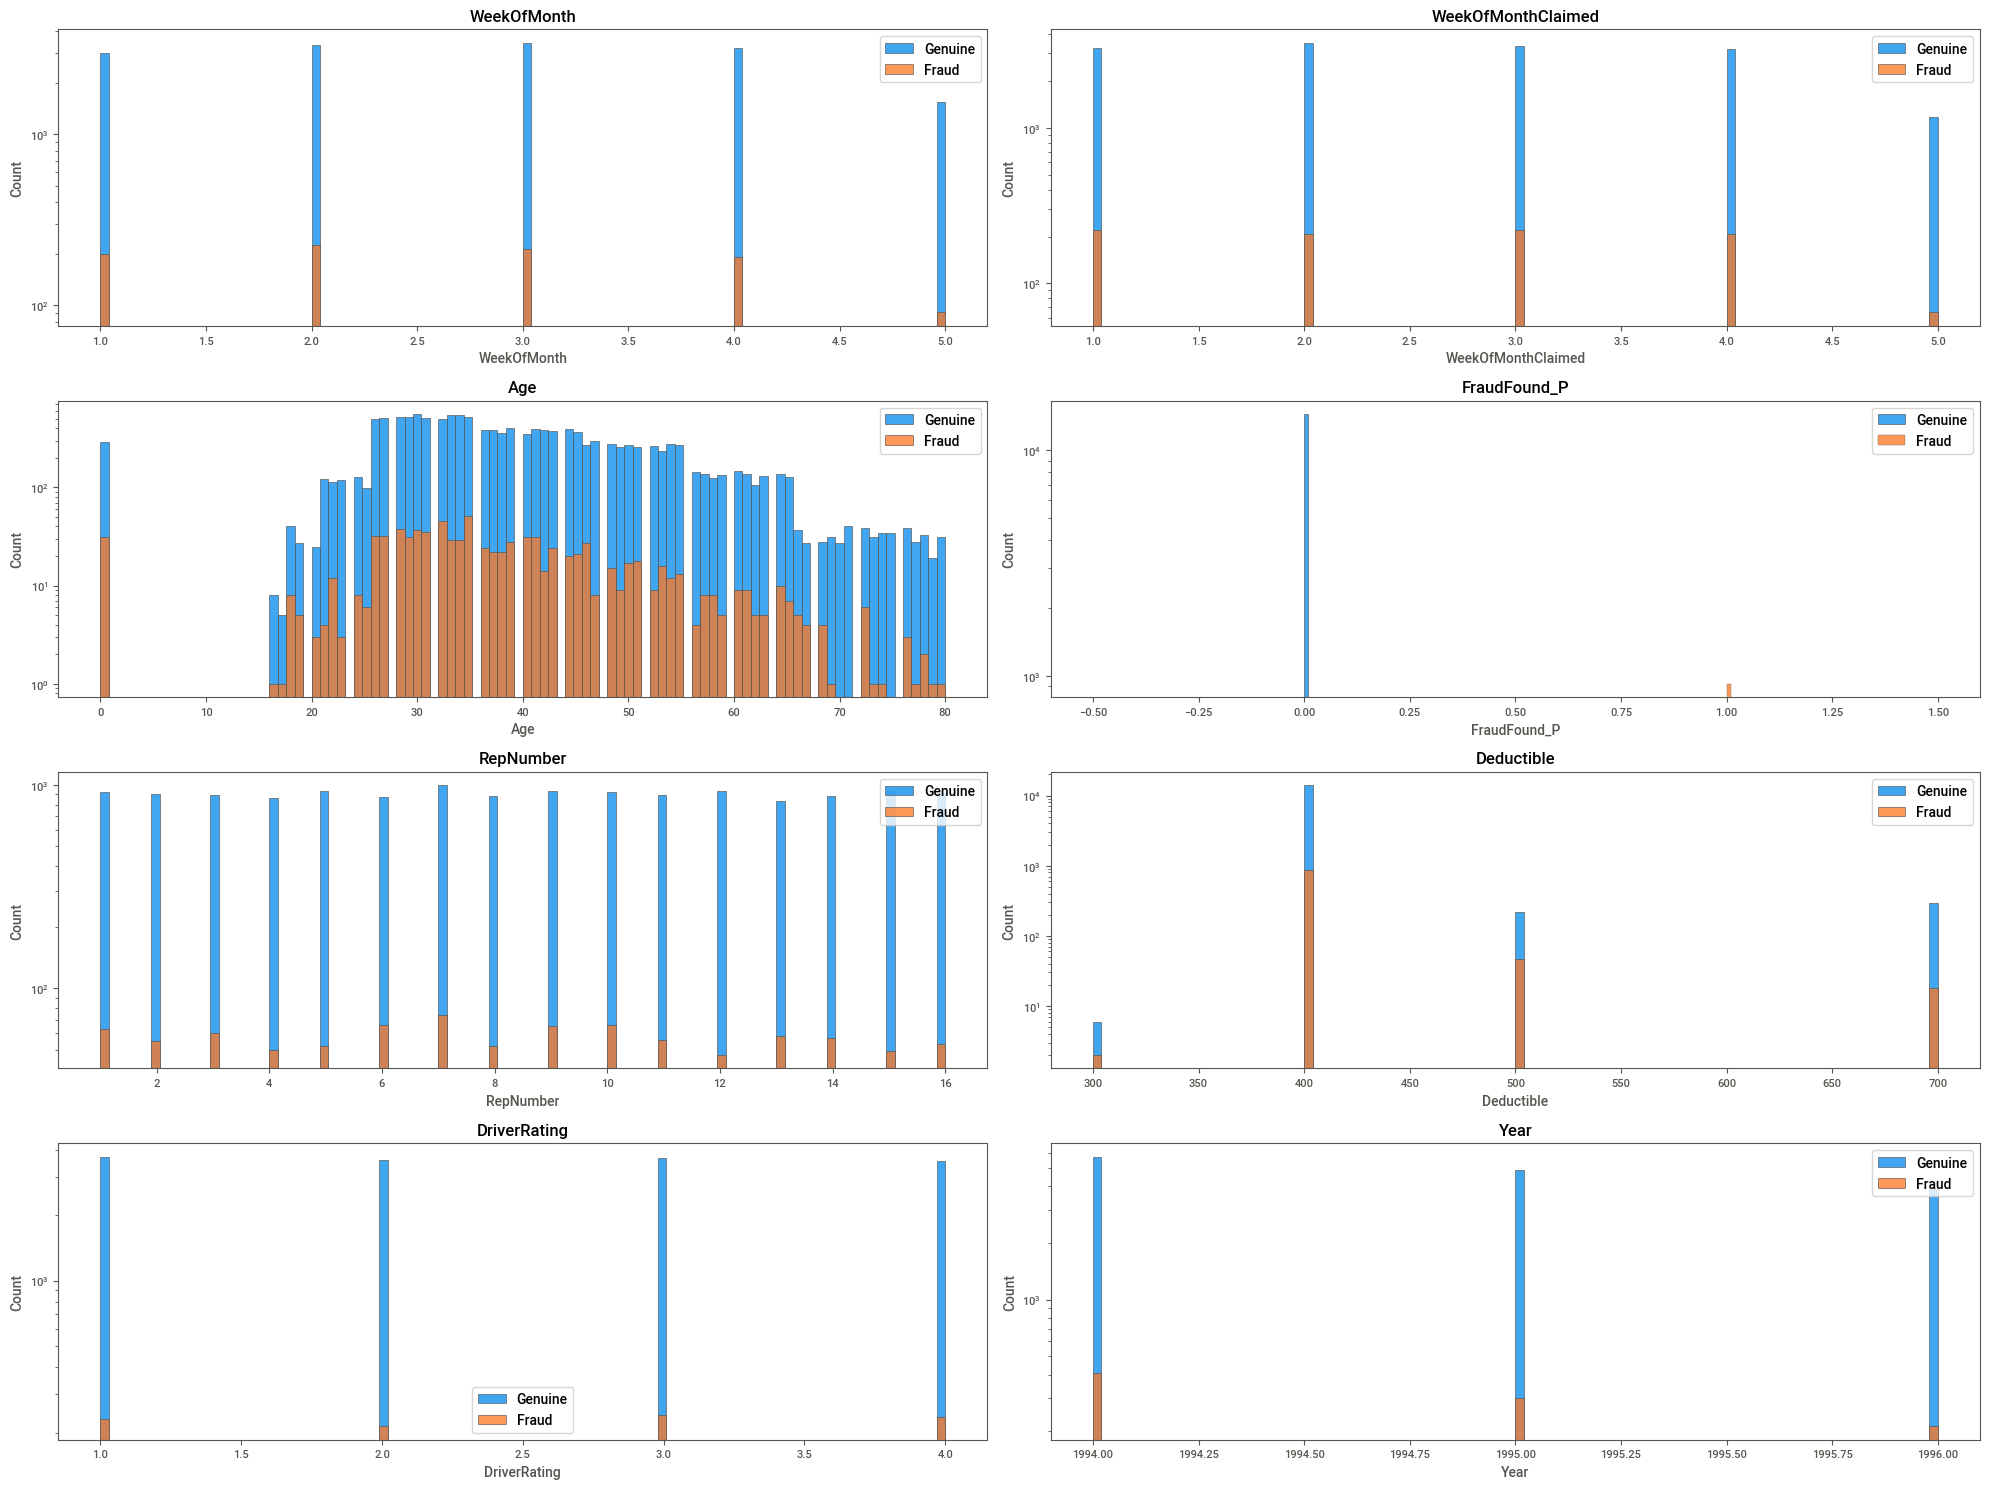

In [106]:
def plot_numerical_features(features):    
    fig, ax = plt.subplots(4, len(features)//4, figsize=(20, 15))
    i = 0
    for feature in features:
        i += 1
        plt.subplot(4, len(features)//4, i)
        sns.histplot(df[df['FraudFound_P']==0][feature], bins=100, label="Genuine")
        sns.histplot(df[df['FraudFound_P']==1][feature], bins=100, label="Fraud")
        plt.title(feature)
        plt.yscale('log')
        plt.legend()
    fig.tight_layout() 
    plt.show()

plot_numerical_features(df.select_dtypes(["int", "float"]).columns)

In [107]:
df.select_dtypes(["object"]).columns

Index(['Month', 'DayOfWeek', 'Make', 'AccidentArea', 'DayOfWeekClaimed',
       'MonthClaimed', 'Sex', 'MaritalStatus', 'Fault', 'PolicyType',
       'VehicleCategory', 'VehiclePrice', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars',
       'BasePolicy'],
      dtype='object')

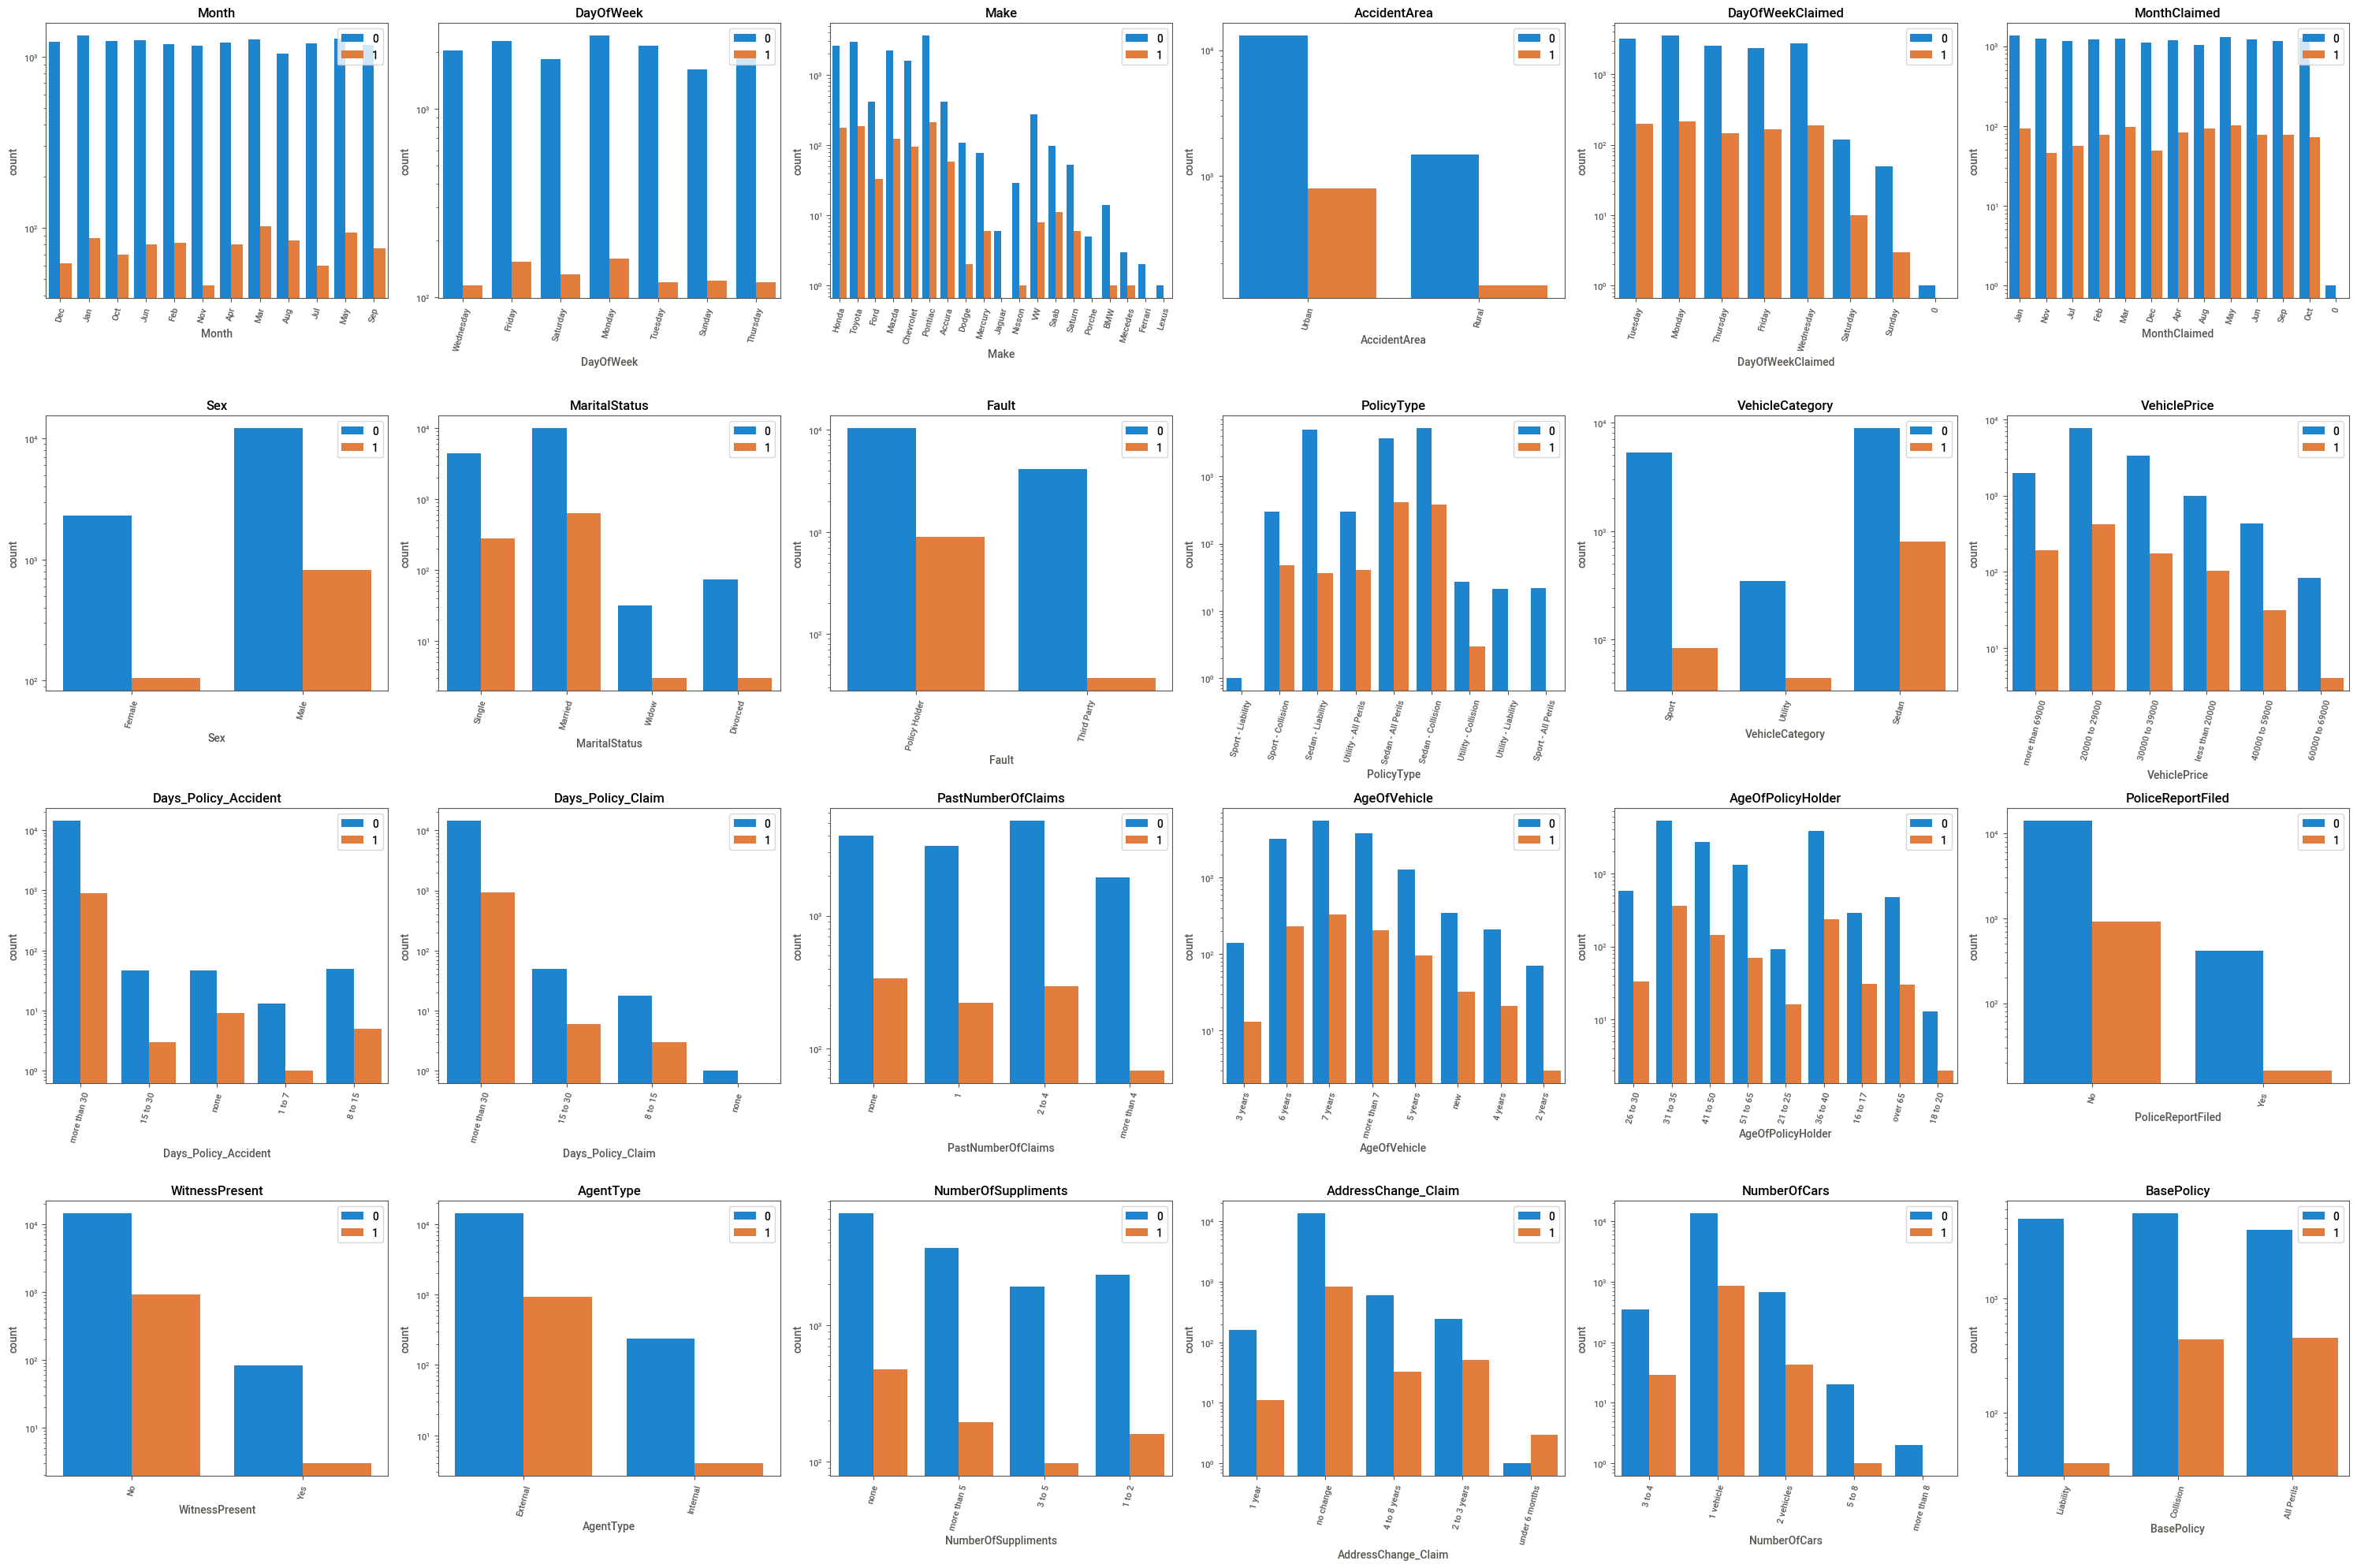

In [108]:
def bivariate_countplot(features):    
    fig, ax = plt.subplots(4, len(features)//4, figsize=(30, 20))
    i = 0
    for feature in features:
        i += 1
        plt.subplot(4, len(features)//4, i)
        ax=sns.countplot(data=df, x=feature, hue='FraudFound_P')
        ax.tick_params(axis='x', labelrotation = 75)
        plt.title(feature)
        plt.yscale('log')
        plt.legend()
    fig.tight_layout() 
    plt.show()

bivariate_countplot(df.select_dtypes(["object"]).columns)

In [109]:
df_one_hot = pd.concat([df.select_dtypes(["int", "float"]), pd.get_dummies(df.select_dtypes(["object"])).astype(int)], axis=1)

## 5. model training and evaluation

In [110]:
X = df_one_hot[[c for c in df_one_hot.columns if c not in ["FraudFound_P"]]]
y = df_one_hot["FraudFound_P"]

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
# pip install xgboost==1.7.5

#### 5.2.1 sklearn gbt

In [113]:
import time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

start_time = time.time()

# Set the parameters to search over
param_dist = {'max_depth': randint(1, 30),
              'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5],
              'n_estimators': randint(10, 100)}

# Create a GradientBoostingClassifier model
gb = GradientBoostingClassifier(random_state=42)

# Run randomized search
rand_search = RandomizedSearchCV(gb, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, scoring="average_precision")

# Fit the randomized search to the training data
rand_search.fit(X_train, y_train)

# Print the best hyperparameters
print('Best hyperparameters:', rand_search.best_params_)

# Return the trained model
model_sklearn = rand_search.best_estimator_

print("Total time:", time.time()-start_time)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 538, in fit
    n_stages = self._fit_stages(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 641, in _fit_stages
    self.train_score_[i] = loss_(y, raw_predictions, sample_weight)
  File "/opt/a

Best hyperparameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 63}
Total time: 1669.2472109794617


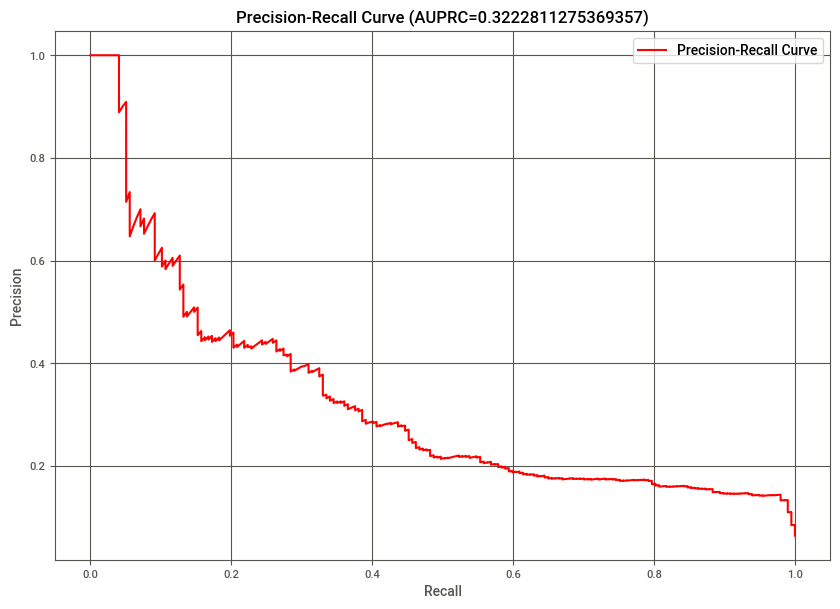

In [114]:
plt.figure(figsize=(10,7))
y_pred_prob = model_sklearn.predict_proba(X_test)
# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])
auprc = average_precision_score(y_test, y_pred_prob[:,1])
# Plot precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve', color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUPRC={auprc})')
plt.legend()
plt.grid(True)

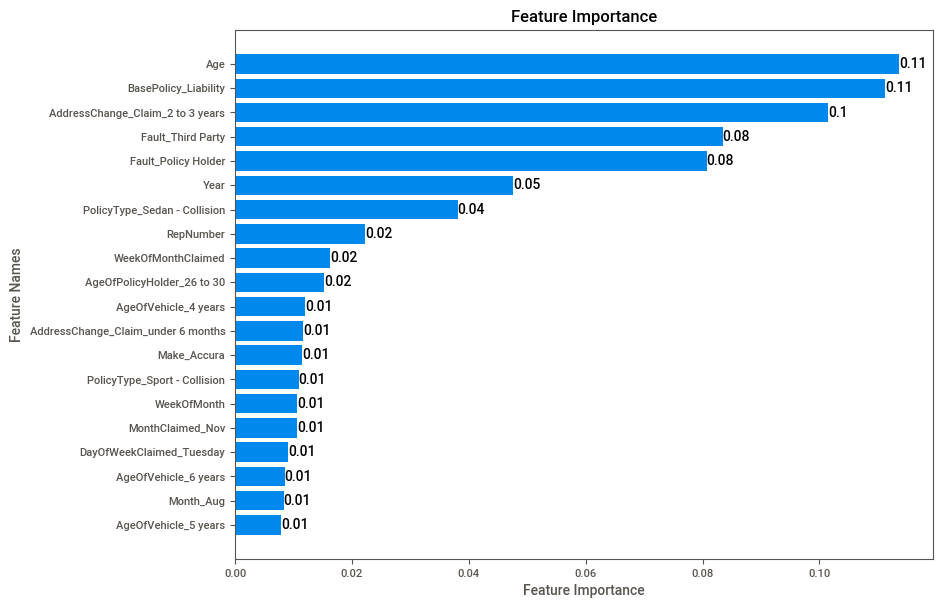

In [115]:
def plot_feature_importances(model):
    plt.figure(figsize=(9, 7))

    sorted_features = sorted(zip(model.feature_names_in_, model.feature_importances_), key=lambda c: abs(c[1]))
    sorted_names, sorted_imp = zip(*sorted_features[-20:])

    plt.barh(range(len(sorted_imp)), sorted_imp, align='center')
    for i, v in enumerate(sorted_imp):
        plt.text(v, i, str(round(v, 2)), va='center')
    plt.yticks(range(len(sorted_imp)), sorted_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.title('Feature Importance')

    plt.show()
plot_feature_importances(model_sklearn)

#### 5.2.2 xgboost gbt

In [116]:
# conda install catboost

In [117]:
start_time = time.time()

from xgboost import XGBClassifier

# Set the parameters to search over
param_dist = {'max_depth': randint(1, 30),
              'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5],
              'n_estimators': randint(10, 100)}

# Create an XGBoost model
xgb = XGBClassifier(random_state=42)

# Run randomized search
rand_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, scoring="average_precision")

# Fit the randomized search to the training data
rand_search.fit(X_train, y_train)

# Print the best hyperparameters
print('Best hyperparameters:', rand_search.best_params_)

# return the trained model
model_xgb = rand_search.best_estimator_

print("Total time:", time.time()-start_time)

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 70}
Total time: 606.789008140564


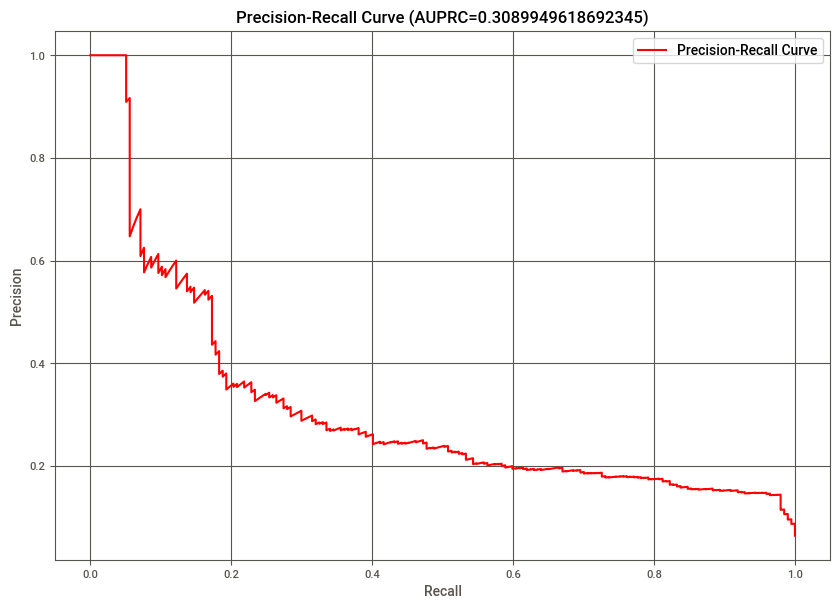

In [118]:
plt.figure(figsize=(10,7))
y_pred_prob = model_xgb.predict_proba(X_test)
# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])
auprc = average_precision_score(y_test, y_pred_prob[:,1])
# Plot precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve', color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUPRC={auprc})')
plt.legend()
plt.grid(True)

In [119]:
rand_search.best_score_

0.24178565405080032

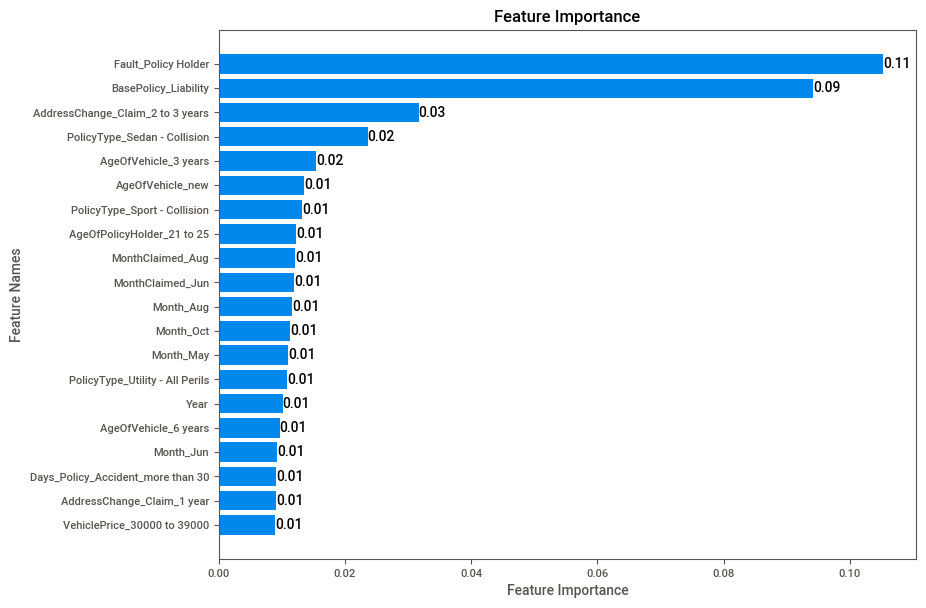

In [120]:
def plot_feature_importances(model):
    plt.figure(figsize=(9, 7))

    sorted_features = sorted(zip(model.feature_names_in_, model.feature_importances_), key=lambda c: abs(c[1]))
    sorted_names, sorted_imp = zip(*sorted_features[-20:])

    plt.barh(range(len(sorted_imp)), sorted_imp, align='center')
    for i, v in enumerate(sorted_imp):
        plt.text(v, i, str(round(v, 2)), va='center')
    plt.yticks(range(len(sorted_imp)), sorted_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.title('Feature Importance')

    plt.show()
plot_feature_importances(model_xgb)

#### 5.2.3 lightgbm gbt

In [121]:
# for c in df.select_dtypes(["object"]).columns:
#     df[c] = df[c].map(lambda c: c.decode("utf-8") if type(c) != str else c) 

In [122]:
# !conda install -y lightgbm

In [123]:
import time
from lightgbm import LGBMClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

start_time = time.time()

# Set the parameters to search over
param_dist = {'max_depth': randint(1, 30),
              'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5],
              'n_estimators': randint(10, 100)}

# Create a LightGBM model
lgbm = LGBMClassifier(random_state=42)

# Run randomized search
rand_search = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, scoring="average_precision")

# Fit the randomized search to the training data
rand_search.fit(X_train, y_train)

# Print the best hyperparameters
print('Best hyperparameters:', rand_search.best_params_)

# return the trained model
model_lgbm = rand_search.best_estimator_

print("Total time:", time.time()-start_time)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

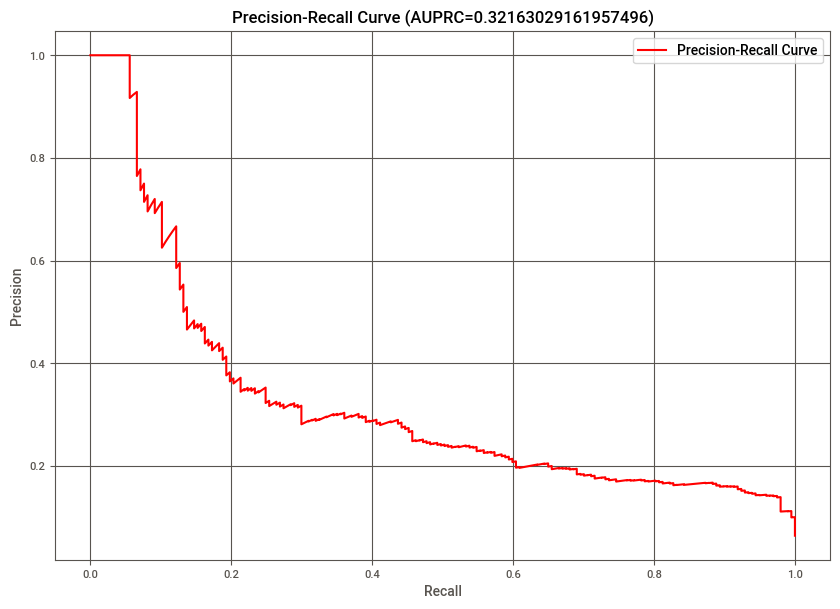

In [124]:
plt.figure(figsize=(10,7))
y_pred_prob = model_lgbm.predict_proba(X_test)
# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])
auprc = average_precision_score(y_test, y_pred_prob[:,1])
# Plot precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve', color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUPRC={auprc})')
plt.legend()
plt.grid(True)

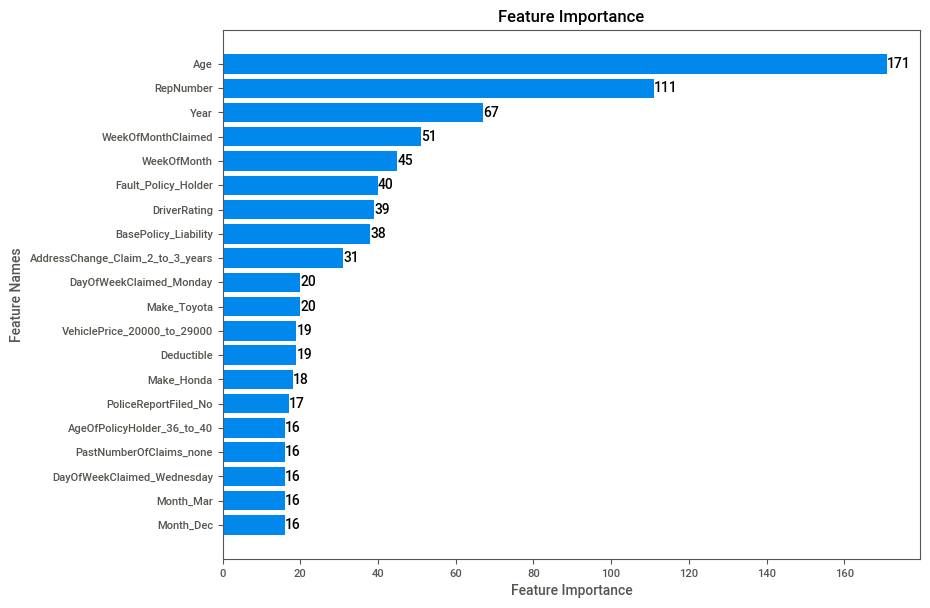

In [125]:
def plot_feature_importances(model):
    plt.figure(figsize=(9, 7))

    sorted_features = sorted(zip(model.feature_name_, model.feature_importances_), key=lambda c: abs(c[1]))
    sorted_names, sorted_imp = zip(*sorted_features[-20:])

    plt.barh(range(len(sorted_imp)), sorted_imp, align='center')
    for i, v in enumerate(sorted_imp):
        plt.text(v, i, str(round(v, 2)), va='center')
    plt.yticks(range(len(sorted_imp)), sorted_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.title('Feature Importance')

    plt.show()
plot_feature_importances(model_lgbm)

#### 5.2.4 catboost

In [126]:
from catboost import CatBoostClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

start_time = time.time()

# Set the parameters to search over
param_dist = {'depth': randint(1, 100),
              'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5],
              'iterations': randint(10, 400)}

# Create a CatBoost model
catboost = CatBoostClassifier(random_state=42)

# Run randomized search
rand_search = RandomizedSearchCV(catboost, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, scoring="average_precision")

# Fit the randomized search to the training data
rand_search.fit(X_train, y_train, logging_level='Silent',
                cat_features=X_train.select_dtypes("object").columns.tolist())

# Print the best hyperparameters
print('Best hyperparameters:', rand_search.best_params_)

# Return the trained model
model_cat = rand_search.best_estimator_

print("Total time:", time.time()-start_time)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
390 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
390 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 1981

Best hyperparameters: {'depth': 9, 'iterations': 216, 'learning_rate': 0.05}
Total time: 1723.8110690116882


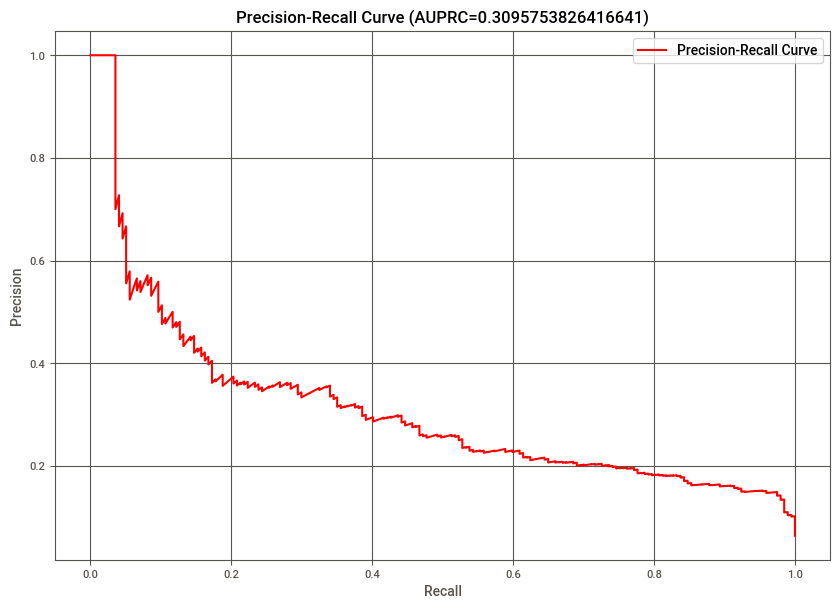

In [127]:
plt.figure(figsize=(10,7))
y_pred_prob = model_cat.predict_proba(X_test)
# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])
auprc = average_precision_score(y_test, y_pred_prob[:,1])
# Plot precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve', color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUPRC={auprc})')
plt.legend()
plt.grid(True)

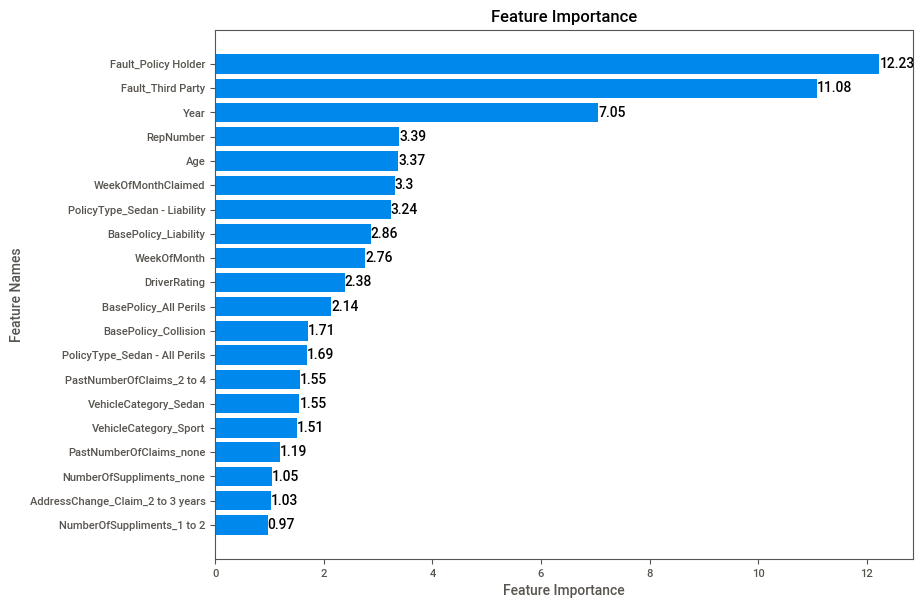

In [128]:
def plot_feature_importances(model):
    plt.figure(figsize=(9, 7))

    sorted_features = sorted(zip(model.feature_names_, model.feature_importances_), key=lambda c: abs(c[1]))
    sorted_names, sorted_imp = zip(*sorted_features[-20:])

    plt.barh(range(len(sorted_imp)), sorted_imp, align='center')
    for i, v in enumerate(sorted_imp):
        plt.text(v, i, str(round(v, 2)), va='center')
    plt.yticks(range(len(sorted_imp)), sorted_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.title('Feature Importance')

    plt.show()
plot_feature_importances(model_cat)

In [129]:
X = df[[c for c in df.columns if c not in ["FraudFound_P"]]]
y = df["FraudFound_P"]

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
from catboost import CatBoostClassifier
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

start_time = time.time()

# Set the parameters to search over
param_dist = {'depth': randint(1, 100),
              'learning_rate': [0.01, 0.05, 0.1, 0.25, 0.5],
              'iterations': randint(10, 400)}

# Create a CatBoost model
catboost = CatBoostClassifier(random_state=42)

# Run randomized search
rand_search = RandomizedSearchCV(catboost, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, scoring="average_precision")

# Fit the randomized search to the training data
rand_search.fit(X_train, y_train, logging_level='Silent',
                cat_features=X_train.select_dtypes("object").columns.tolist())

# Print the best hyperparameters
print('Best hyperparameters:', rand_search.best_params_)

# Return the trained model
model_cat2 = rand_search.best_estimator_

print("Total time:", time.time()-start_time)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
390 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
390 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 4675, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/anaconda3/lib/python3.8/site-packages/catboost/core.py", line 1981

Best hyperparameters: {'depth': 5, 'iterations': 227, 'learning_rate': 0.1}
Total time: 1333.9717960357666


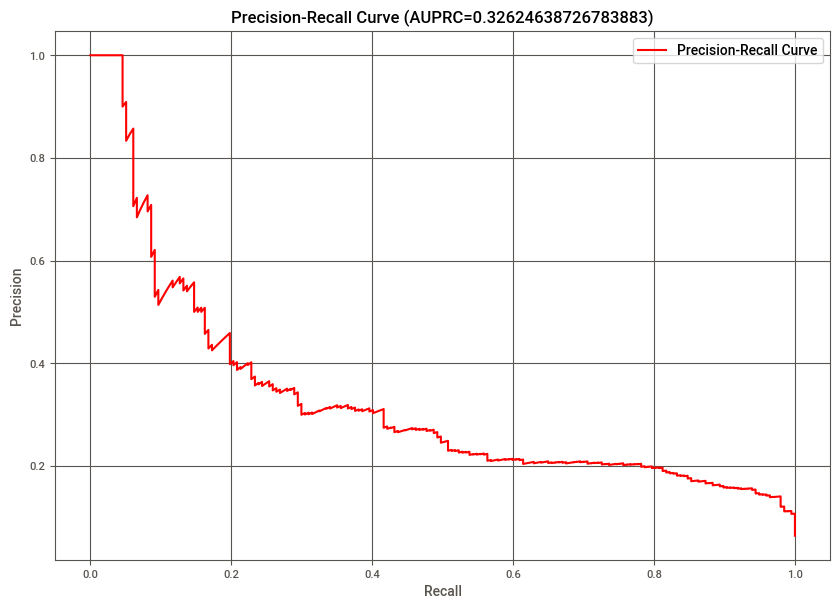

In [132]:
plt.figure(figsize=(10,7))
y_pred_prob = model_cat2.predict_proba(X_test)
# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])
auprc = average_precision_score(y_test, y_pred_prob[:,1])
# Plot precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve', color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUPRC={auprc})')
plt.legend()
plt.grid(True)

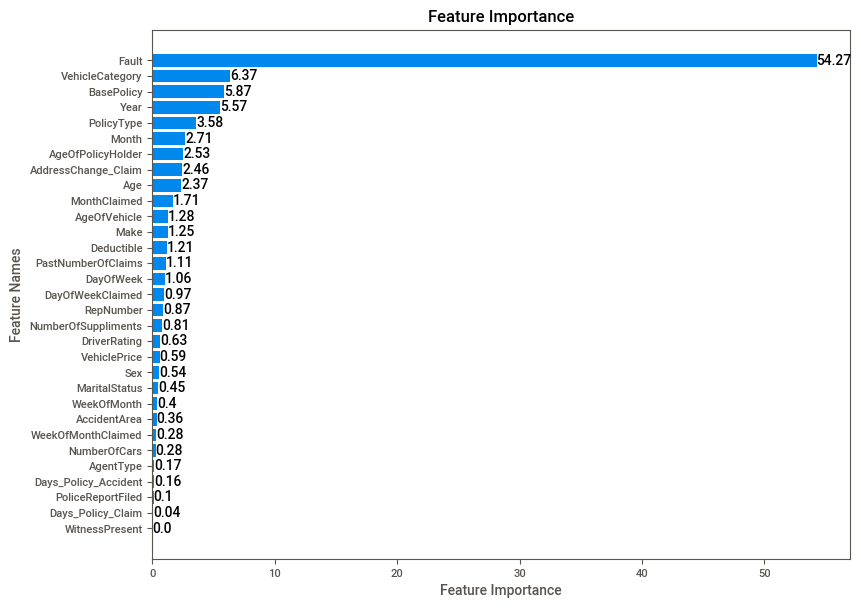

In [133]:
def plot_feature_importances(model):
    plt.figure(figsize=(9, 7))

    sorted_features = sorted(zip(model.feature_names_, model.feature_importances_), key=lambda c: abs(c[1]))
    sorted_names, sorted_imp = zip(*sorted_features)

    plt.barh(range(len(sorted_imp)), sorted_imp, align='center')
    for i, v in enumerate(sorted_imp):
        plt.text(v, i, str(round(v, 2)), va='center')
    plt.yticks(range(len(sorted_imp)), sorted_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.title('Feature Importance')

    plt.show()
plot_feature_importances(model_cat2)

## 6. model interpretability

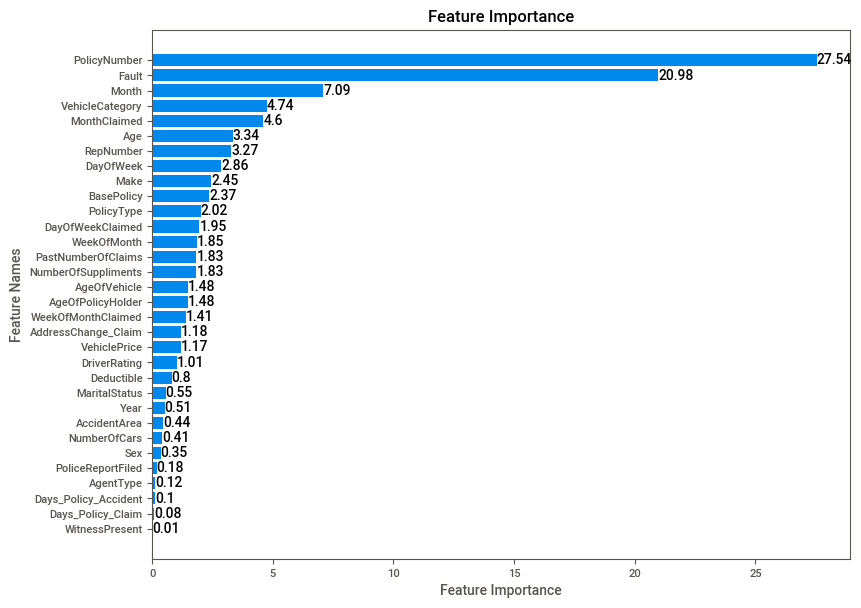

In [47]:
def plot_feature_importances(model):
    plt.figure(figsize=(9, 7))

    sorted_features = sorted(zip(model.feature_names_, model.feature_importances_), key=lambda c: abs(c[1]))
    sorted_names, sorted_imp = zip(*sorted_features)

    plt.barh(range(len(sorted_imp)), sorted_imp, align='center')
    for i, v in enumerate(sorted_imp):
        plt.text(v, i, str(round(v, 2)), va='center')
    plt.yticks(range(len(sorted_imp)), sorted_names)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.title('Feature Importance')

    plt.show()
plot_feature_importances(model)